# Импорты и утилиты

In [ ]:
import os, random, zipfile, urllib.request
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode


In [ ]:
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("torch:", torch.__version__, "torchvision:", torchvision.__version__, "device:", DEVICE)


torch: 2.9.0+cu126 torchvision: 0.24.0+cu126 device: cuda


# Общие трансформации для (image, mask)

In [ ]:
class SegTransform:
    """
    Простейшие согласованные трансформации для пары (image, mask):
    - resize
    - random horizontal flip
    - to tensor
    """
    def __init__(self, size=(256, 256), hflip_p=0.5):
        self.size = size
        self.hflip_p = hflip_p

    def __call__(self, img_pil: Image.Image, mask_pil: Image.Image):
        # Resize: картинку билинейно, маску — nearest (чтобы не “размазывать” классы)
        img = TF.resize(img_pil, self.size, interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask_pil, self.size, interpolation=InterpolationMode.NEAREST)

        # Random flip
        if random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        # To tensor
        img_t = TF.to_tensor(img)  # float32, [0,1], (3,H,W)
        # Маска как long (классы), без нормализации
        mask_t = torch.as_tensor(np.array(mask), dtype=torch.long)

        return img_t, mask_t


# Oxford-IIIT Pet

In [ ]:
class OxfordPetSeg(Dataset):
    """
    Возвращает (image, mask) для семантической сегментации.
    mask_mode:
      - "binary": 0=background, 1=pet (pet+outline -> foreground)
      - "3class": 0/1/2 как есть после приведения (зависит от исходных значений маски)
    """
    def __init__(self, root, split="trainval", size=(256, 256), mask_mode="binary", download=True):
        self.ds = OxfordIIITPet(
            root=root,
            split=split,
            target_types="segmentation",
            download=download
        )
        self.tf = SegTransform(size=size, hflip_p=0.5 if split != "test" else 0.0)
        self.mask_mode = mask_mode

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img_pil, mask_pil = self.ds[idx]  # mask is a trimap PIL image
        img_t, mask_raw = self.tf(img_pil, mask_pil)

        # Приводим к ожидаемым классам.
        # Во многих реализациях trimap хранит значения {1,2,3}; ниже делаем сдвиг в {0,1,2}.
        # Чтобы не гадать “по памяти”, проверим уникальные значения на практике (см. ниже ячейку sanity-check).
        mask = mask_raw.clone()
        uniq = torch.unique(mask)

        if uniq.min() >= 1 and uniq.max() <= 3:
            mask = mask - 1  # 0..2

        if self.mask_mode == "binary":
            # считаем background классом 1, остальное — foreground
            # (если захотите считать outline фоном — сделаем (mask==0) и т.п.)
            mask = (mask != 1).long()

        return img_t, mask


# Penn-Fudan — скачивание и датасет (как бинарная семантическая сегментация)
Официальная структура из туториала: PNGImages/ и PedMasks/, zip качается с UPenn.

In [ ]:
from pathlib import Path

DATA_ROOT = "/content/data"
print("Oxford images exists:", Path(DATA_ROOT, "oxford-iiit-pet", "images").exists())


Oxford images exists: False


In [ ]:
def download_and_extract_pennfudan(root: str):
    root = Path(root)
    root.mkdir(parents=True, exist_ok=True)

    zip_path = root / "PennFudanPed.zip"
    out_dir = root / "PennFudanPed"

    if out_dir.exists():
        return out_dir

    url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
    print("Downloading:", url)
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting:", zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(root)

    return out_dir

class PennFudanSemantic(Dataset):
    """
    Бинарная семантическая маска:
      0 = background
      1 = pedestrian (объединяем все инстансы)
    """
    def __init__(self, root, size=(256, 256), tf=None):
        data_dir = download_and_extract_pennfudan(root)
        self.img_dir = data_dir / "PNGImages"
        self.mask_dir = data_dir / "PedMasks"
        self.imgs = sorted(self.img_dir.glob("*.png"))
        self.masks = sorted(self.mask_dir.glob("*_mask.png"))
        assert len(self.imgs) == len(self.masks)

        self.tf = tf  # сюда передадим SegTransform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_pil = Image.open(self.imgs[idx]).convert("RGB")
        mask_pil = Image.open(self.masks[idx])

        if self.tf is not None:
            img_t, mask_raw = self.tf(img_pil, mask_pil)
        else:
            # fallback: без трансформаций
            img_t = torch.from_numpy(np.array(img_pil)).permute(2,0,1).float() / 255.0
            mask_raw = torch.from_numpy(np.array(mask_pil)).long()

        mask = (mask_raw > 0).long()
        return img_t, mask


# Sanity-check и визуализация

In [ ]:
def show_sample(ds, idx=0, title=""):
    img, mask = ds[idx]
    img_np = img.permute(1,2,0).numpy()
    mask_np = mask.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(img_np)
    ax[0].set_title(f"{title} | image")
    ax[0].axis("off")

    ax[1].imshow(mask_np)
    ax[1].set_title(f"{title} | mask | uniq={np.unique(mask_np)}")
    ax[1].axis("off")

    plt.show()


100%|██████████| 792M/792M [00:28<00:00, 28.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 13.3MB/s]


Downloading: https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Extracting: /content/data/PennFudanPed.zip
OxfordPet train: 3680 test: 3669
PennFudan: 170


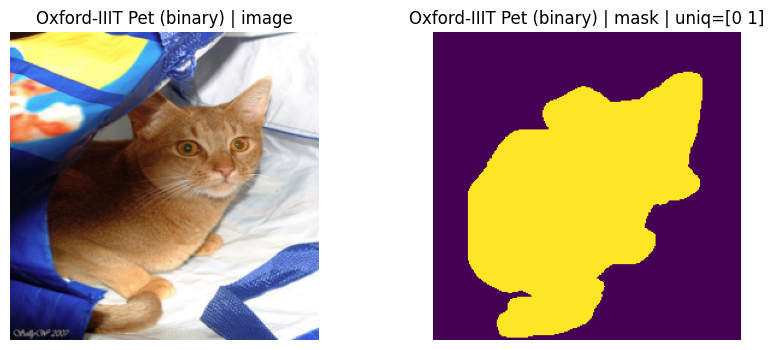

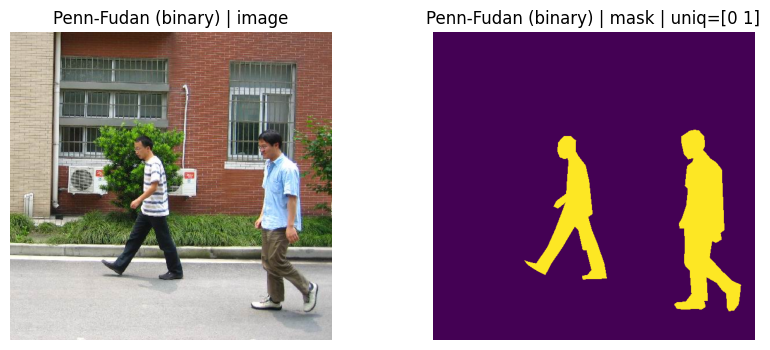

In [ ]:
pet_train = OxfordPetSeg(DATA_ROOT, split="trainval", size=(256,256), mask_mode="binary", download=True)
pet_test  = OxfordPetSeg(DATA_ROOT, split="test",     size=(256,256), mask_mode="binary", download=True)

penn = PennFudanSemantic(DATA_ROOT, size=(256,256))

print("OxfordPet train:", len(pet_train), "test:", len(pet_test))
print("PennFudan:", len(penn))

show_sample(pet_train, idx=0, title="Oxford-IIIT Pet (binary)")
show_sample(penn, idx=0, title="Penn-Fudan (binary)")


# DataLoader

- Учим самую простую модель сегментации с нуля на Oxford-IIIT Pet.

- Маска бинарная: 0=background, 1=object.

- Лосс: BCEWithLogitsLoss (логиты + сигмоида внутри лосса).

Напоминание:

в torchvision.datasets.OxfordIIITPet для target_types="segmentation" возвращается segmentation trimap (PIL), мы её заранее схлопнули в бинарную маску.

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = 2  # в Colab можно 2-4

pin = torch.cuda.is_available()  # True только если есть GPU (CUDA)

train_loader = DataLoader(pet_train, batch_size=16, shuffle=True,
                          num_workers=2, pin_memory=pin)

val_loader = DataLoader(pet_test, batch_size=16, shuffle=False,
                        num_workers=2, pin_memory=pin)



# Простая модель сегментации (минимальный encoder-decoder)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TinySegNet(nn.Module):
    """
    Минимальный encoder-decoder:
    down: conv -> conv -> pool
    bottleneck
    up: transposed conv -> conv -> conv
    выход: 1 канал (логиты)
    """
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(inplace=True),
        )

        self.head = nn.Conv2d(16, 1, kernel_size=1)  # логиты

    def forward(self, x):
        x = self.enc1(x)
        x = self.pool1(x)

        x = self.enc2(x)
        x = self.pool2(x)

        x = self.bottleneck(x)

        x = self.up2(x)
        x = self.dec2(x)

        x = self.up1(x)
        x = self.dec1(x)

        return self.head(x)


## Метрики IoU и Dice (для бинарной маски)

In [ ]:
@torch.no_grad()
def iou_dice_from_logits(logits: torch.Tensor, target: torch.Tensor, thr: float = 0.5, eps: float = 1e-7):
    """
    logits: (B,1,H,W)
    target: (B,H,W) или (B,1,H,W) с 0/1
    """
    if target.ndim == 3:
        target = target.unsqueeze(1)
    target = target.float()

    prob = torch.sigmoid(logits)
    pred = (prob > thr).float()

    inter = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred * target).sum(dim=(1,2,3))

    iou = (inter + eps) / (union + eps)
    dice = (2*inter + eps) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps)

    return iou.mean().item(), dice.mean().item()


## Train / Eval loop

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)  # (B,H,W) long

        # BCEWithLogitsLoss ждёт float target того же shape, что и logits
        target = masks.unsqueeze(1).float()  # (B,1,H,W)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        iou, dice = iou_dice_from_logits(logits.detach(), masks.detach())

        total_loss += loss.item()
        total_iou += iou
        total_dice += dice

    n = len(loader)
    return total_loss/n, total_iou/n, total_dice/n


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        target = masks.unsqueeze(1).float()
        logits = model(imgs)

        loss = criterion(logits, target)
        iou, dice = iou_dice_from_logits(logits, masks)

        total_loss += loss.item()
        total_iou += iou
        total_dice += dice

    n = len(loader)
    return total_loss/n, total_iou/n, total_dice/n


## Запуск обучения на 1–3 эпохи

In [ ]:
model = TinySegNet().to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 3

for epoch in range(EPOCHS):
    tr_loss, tr_iou, tr_dice = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va_loss, va_iou, va_dice = evaluate(model, val_loader, criterion, DEVICE)

    print(
        f"Epoch {epoch+1:02d} | "
        f"train: loss={tr_loss:.4f}, IoU={tr_iou:.3f}, Dice={tr_dice:.3f} | "
        f"val:   loss={va_loss:.4f}, IoU={va_iou:.3f}, Dice={va_dice:.3f}"
    )


Epoch 01 | train: loss=0.6478, IoU=0.124, Dice=0.167 | val:   loss=0.6018, IoU=0.257, Dice=0.372
Epoch 02 | train: loss=0.5402, IoU=0.507, Dice=0.650 | val:   loss=0.4797, IoU=0.606, Dice=0.740
Epoch 03 | train: loss=0.4695, IoU=0.581, Dice=0.721 | val:   loss=0.4475, IoU=0.572, Dice=0.713


## Визуализация предсказания

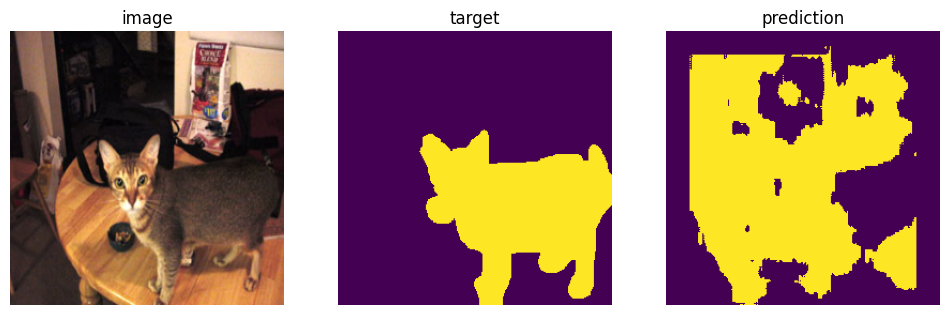

In [ ]:
@torch.no_grad()
def show_pred(model, ds, idx=0):
    model.eval()
    img, mask = ds[idx]
    logits = model(img.unsqueeze(0).to(DEVICE)).cpu()
    pred = (torch.sigmoid(logits)[0,0] > 0.5).numpy()

    img_np = img.permute(1,2,0).numpy()
    mask_np = mask.numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_np); ax[0].set_title("image"); ax[0].axis("off")
    ax[1].imshow(mask_np); ax[1].set_title("target"); ax[1].axis("off")
    ax[2].imshow(pred); ax[2].set_title("prediction"); ax[2].axis("off")
    plt.show()

show_pred(model, pet_test, idx=0)


# Простая модель сегментации c более умным обучением

In [ ]:
pin = torch.cuda.is_available()

BATCH_SIZE = 20
NUM_WORKERS = 2

train_loader = DataLoader(
    pet_train, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=pin
)
val_loader = DataLoader(
    pet_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=pin
)

print("pin_memory:", pin)


pin_memory: True


## Метрики: IoU, Dice + pixel accuracy

In [ ]:
@torch.no_grad()
def metrics_from_logits(logits: torch.Tensor, target: torch.Tensor, thr: float = 0.5, eps: float = 1e-7):
    """
    logits: (B,1,H,W)
    target: (B,H,W) или (B,1,H,W) с 0/1
    """
    if target.ndim == 3:
        target_ = target.unsqueeze(1)
    else:
        target_ = target
    target_ = target_.float()

    prob = torch.sigmoid(logits)
    pred = (prob > thr).float()

    inter = (pred * target_).sum(dim=(1,2,3))
    union = (pred + target_ - pred * target_).sum(dim=(1,2,3))

    iou = (inter + eps) / (union + eps)
    dice = (2 * inter + eps) / (pred.sum(dim=(1,2,3)) + target_.sum(dim=(1,2,3)) + eps)

    pix_acc = (pred == target_).float().mean(dim=(1,2,3))

    return iou.mean().item(), dice.mean().item(), pix_acc.mean().item()


## Train/Eval на эпоху

`BCEWithLogitsLoss` - требует одинаковую форму input и target (поэтому делаем `mask.unsqueeze(1).float()`).

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    sums = {"loss": 0.0, "iou": 0.0, "dice": 0.0, "acc": 0.0}

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)          # (B,H,W) long
        target = masks.unsqueeze(1).float()                  # (B,1,H,W)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        iou, dice, acc = metrics_from_logits(logits.detach(), masks.detach())

        sums["loss"] += loss.item()
        sums["iou"]  += iou
        sums["dice"] += dice
        sums["acc"]  += acc

    n = len(loader)
    return {k: v/n for k, v in sums.items()}


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    sums = {"loss": 0.0, "iou": 0.0, "dice": 0.0, "acc": 0.0}

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        target = masks.unsqueeze(1).float()

        logits = model(imgs)
        loss = criterion(logits, target)
        iou, dice, acc = metrics_from_logits(logits, masks)

        sums["loss"] += loss.item()
        sums["iou"]  += iou
        sums["dice"] += dice
        sums["acc"]  += acc

    n = len(loader)
    return {k: v/n for k, v in sums.items()}


## Scheduler + лучший чекпоинт (и возможность resume)

- `ReduceLROnPlateau` снижает LR, если метрика “застряла”; важно вызывать scheduler.step(val_loss) после валидации.
docs.pytorch.org

- Сохраняем полный чекпоинт (model/optimizer/scheduler/epoch/metrics). PyTorch рекомендует работать через state_dict.

In [ ]:
from pathlib import Path

def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def save_checkpoint(path, model, optimizer, scheduler, epoch, best_score, history):
    ckpt = {
        "epoch": epoch,
        "best_score": best_score,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "sched_state": None if scheduler is None else scheduler.state_dict(),
        "history": history,
    }
    torch.save(ckpt, path)  # state_dict best-practice :contentReference[oaicite:3]{index=3}

def load_checkpoint(path, model, optimizer=None, scheduler=None, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and "optim_state" in ckpt:
        optimizer.load_state_dict(ckpt["optim_state"])
    if scheduler is not None and ckpt.get("sched_state") is not None:
        scheduler.load_state_dict(ckpt["sched_state"])
    return ckpt


## Основной цикл: логирование, LR-контроль, best model

Критерий “лучший” обычно удобно брать val_dice или val_iou (берем Dice).

In [ ]:
import torch.nn as nn

model = TinySegNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# LR scheduler: уменьшаем LR, если val_loss не улучшается :contentReference[oaicite:4]{index=4}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, #verbose=True
)

EPOCHS = 20
ckpt_dir = Path("./checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)
best_path = ckpt_dir / "best_tinyseg_pet.pth"

history = {
    "train_loss": [], "val_loss": [],
    "train_iou": [],  "val_iou": [],
    "train_dice": [], "val_dice": [],
    "train_acc": [],  "val_acc": [],
    "lr": []
}

best_dice = -1.0

for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va = evaluate(model, val_loader, criterion, DEVICE)

    # scheduler step AFTER validation :contentReference[oaicite:5]{index=5}
    scheduler.step(va["loss"])

    lr = get_lr(optimizer)

    history["train_loss"].append(tr["loss"]); history["val_loss"].append(va["loss"])
    history["train_iou"].append(tr["iou"]);   history["val_iou"].append(va["iou"])
    history["train_dice"].append(tr["dice"]); history["val_dice"].append(va["dice"])
    history["train_acc"].append(tr["acc"]);   history["val_acc"].append(va["acc"])
    history["lr"].append(lr)

    # save best by val_dice
    if va["dice"] > best_dice:
        best_dice = va["dice"]
        save_checkpoint(best_path, model, optimizer, scheduler, epoch, best_dice, history)

    print(
        f"Epoch {epoch:02d} | lr={lr:.2e} | "
        f"train: loss={tr['loss']:.4f}, IoU={tr['iou']:.3f}, Dice={tr['dice']:.3f}, Acc={tr['acc']:.3f} | "
        f"val: loss={va['loss']:.4f}, IoU={va['iou']:.3f}, Dice={va['dice']:.3f}, Acc={va['acc']:.3f} | "
        f"bestDice={best_dice:.3f}"
    )

print("Best checkpoint:", best_path)


Epoch 01 | lr=1.00e-03 | train: loss=0.6775, IoU=0.006, Dice=0.008, Acc=0.586 | val: loss=0.6804, IoU=0.002, Dice=0.002, Acc=0.577 | bestDice=0.002
Epoch 02 | lr=1.00e-03 | train: loss=0.6558, IoU=0.061, Dice=0.086, Acc=0.590 | val: loss=0.6313, IoU=0.002, Dice=0.002, Acc=0.577 | bestDice=0.002
Epoch 03 | lr=1.00e-03 | train: loss=0.5989, IoU=0.374, Dice=0.491, Acc=0.646 | val: loss=0.5827, IoU=0.378, Dice=0.511, Acc=0.679 | bestDice=0.511
Epoch 04 | lr=1.00e-03 | train: loss=0.5639, IoU=0.477, Dice=0.612, Acc=0.689 | val: loss=0.5446, IoU=0.522, Dice=0.664, Acc=0.728 | bestDice=0.664
Epoch 05 | lr=1.00e-03 | train: loss=0.5216, IoU=0.528, Dice=0.671, Acc=0.738 | val: loss=0.4865, IoU=0.590, Dice=0.726, Acc=0.766 | bestDice=0.726
Epoch 06 | lr=1.00e-03 | train: loss=0.4818, IoU=0.574, Dice=0.714, Acc=0.772 | val: loss=0.4566, IoU=0.601, Dice=0.736, Acc=0.786 | bestDice=0.736
Epoch 07 | lr=1.00e-03 | train: loss=0.4592, IoU=0.591, Dice=0.728, Acc=0.785 | val: loss=0.4379, IoU=0.621, Dic

## Графики train/val + LR

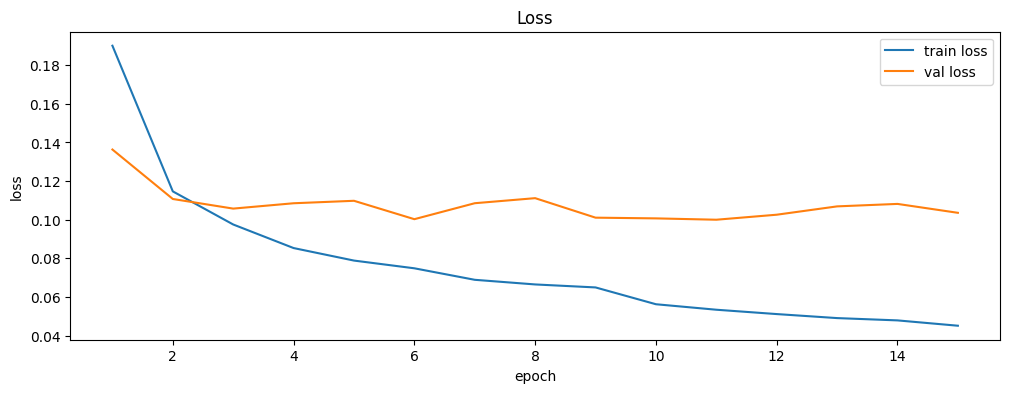

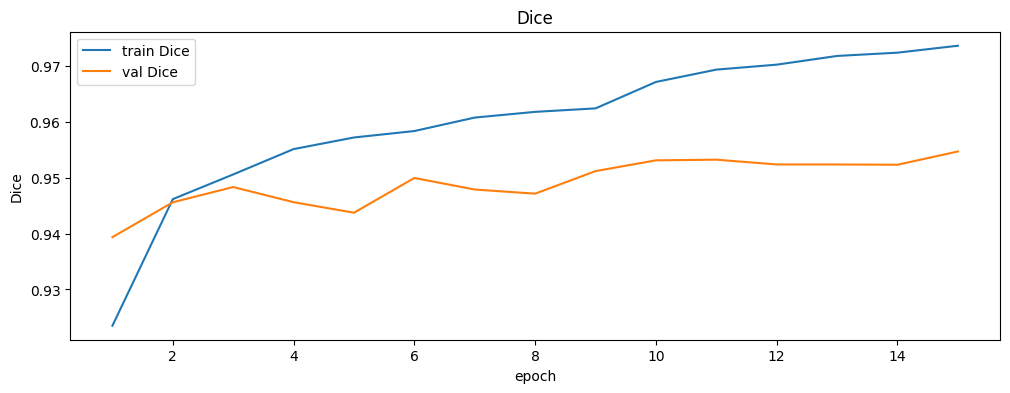

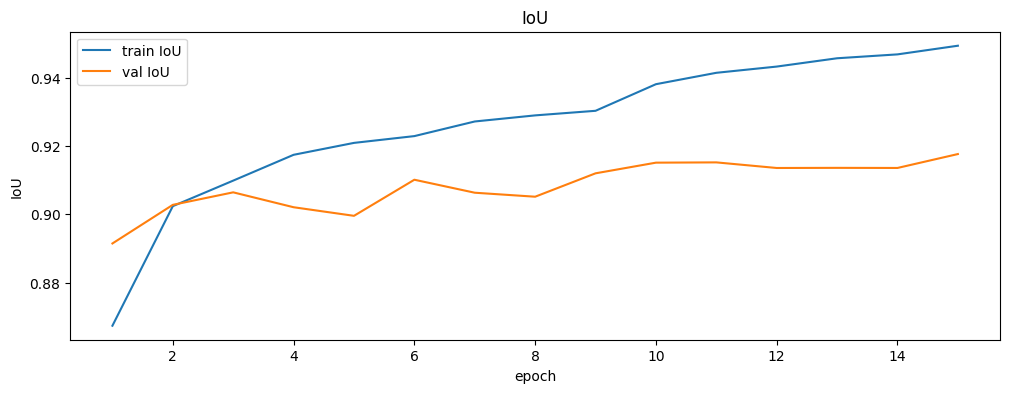

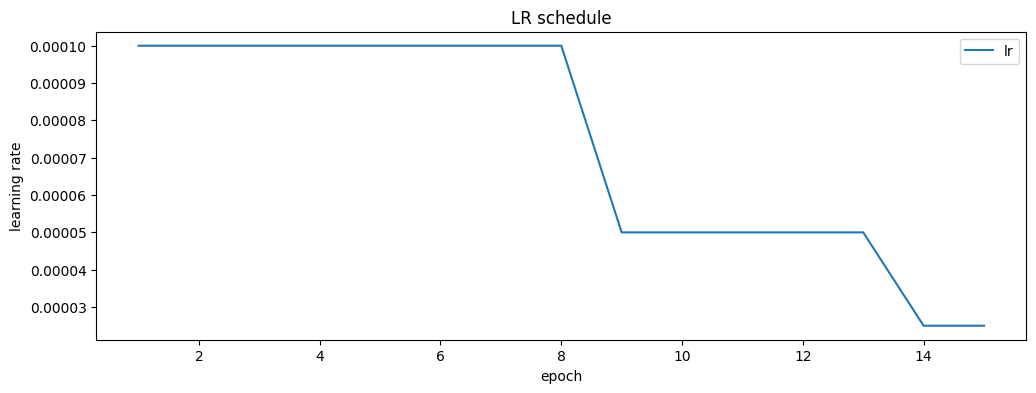

In [21]:
def plot_history(hist):
    epochs = range(1, len(hist["train_loss"]) + 1)

    plt.figure(figsize=(12,4))
    plt.plot(epochs, hist["train_loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(epochs, hist["train_dice"], label="train Dice")
    plt.plot(epochs, hist["val_dice"], label="val Dice")
    plt.xlabel("epoch"); plt.ylabel("Dice"); plt.legend(); plt.title("Dice")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(epochs, hist["train_iou"], label="train IoU")
    plt.plot(epochs, hist["val_iou"], label="val IoU")
    plt.xlabel("epoch"); plt.ylabel("IoU"); plt.legend(); plt.title("IoU")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(epochs, hist["lr"], label="lr")
    plt.xlabel("epoch"); plt.ylabel("learning rate"); plt.legend(); plt.title("LR schedule")
    plt.show()

plot_history(history)


## Загрузить лучший чекпоинт и посмотреть предсказание

Loaded best epoch: 20 best_dice: 0.8061097329077513


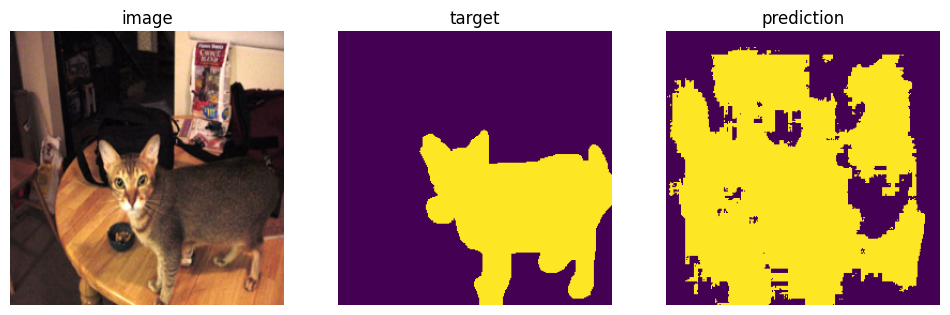

In [ ]:
ckpt = load_checkpoint(best_path, model, map_location=DEVICE)
print("Loaded best epoch:", ckpt["epoch"], "best_dice:", ckpt["best_score"])

show_pred(model, pet_test, idx=0)


# ResNet как бэкбон для сегментации

## Нормализация под pretrained ResNet

Pretrained веса предполагают нормализацию ImageNet (mean/std указаны в описании весов).

In [ ]:
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import functional as TF

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class SegTransformNorm(SegTransform):
    def __init__(self, size=(256,256), hflip_p=0.5, normalize=True):
        super().__init__(size=size, hflip_p=hflip_p)
        self.normalize = normalize

    def __call__(self, img_pil, mask_pil):
        img_t, mask_t = super().__call__(img_pil, mask_pil)
        if self.normalize:
            img_t = TF.normalize(img_t, mean=IMAGENET_MEAN, std=IMAGENET_STD)
        return img_t, mask_t


## Пересоздаём Pet dataset с нормализацией

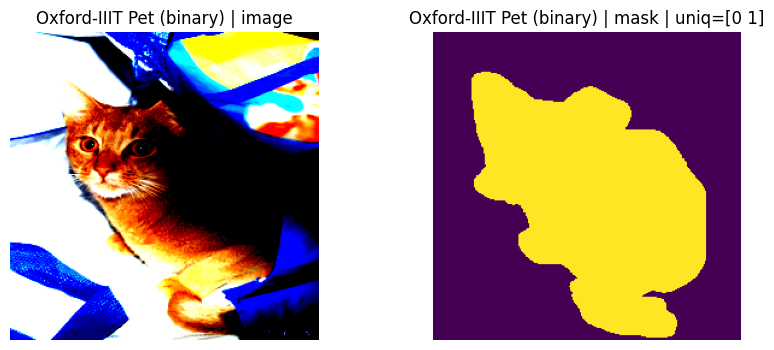

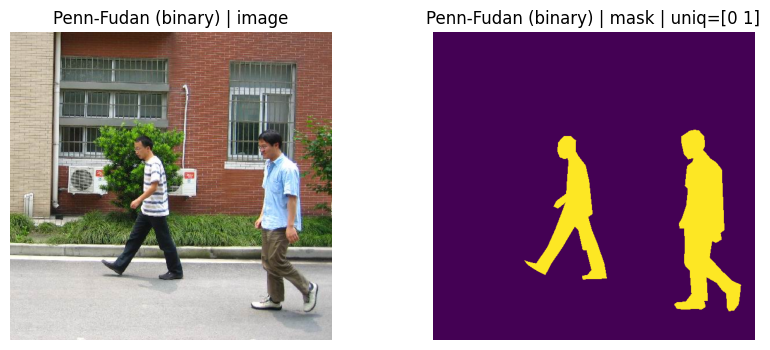

In [ ]:
DATA_ROOT = "/content/data"  # если Colab

pet_train = OxfordPetSeg(DATA_ROOT, split="trainval", size=(256,256), mask_mode="binary", download=True)
pet_test  = OxfordPetSeg(DATA_ROOT, split="test",     size=(256,256), mask_mode="binary", download=True)

# Подменим трансформ на нормализующий (внутри уже resize/flip/to_tensor)
pet_train.tf = SegTransformNorm(size=(256,256), hflip_p=0.5, normalize=True)
pet_test.tf  = SegTransformNorm(size=(256,256), hflip_p=0.0, normalize=True)

show_sample(pet_train, idx=0, title="Oxford-IIIT Pet (binary)")
show_sample(penn, idx=0, title="Penn-Fudan (binary)")


## ResNet encoder через create_feature_extractor

create_feature_extractor позволяет вернуть промежуточные узлы графа (например, layer1..layer4).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.feature_extraction import create_feature_extractor

class ResNetEncoder(nn.Module):
    def __init__(self, weights=ResNet18_Weights.DEFAULT, trainable=False):
        super().__init__()
        backbone = resnet18(weights=weights)  # веса через enum :contentReference[oaicite:4]{index=4}

        # Хотим выходы с разных стадий
        return_nodes = {
            "layer1": "c1",
            "layer2": "c2",
            "layer3": "c3",
            "layer4": "c4",
        }
        self.body = create_feature_extractor(backbone, return_nodes=return_nodes)  # :contentReference[oaicite:5]{index=5}

        if not trainable:
            for p in self.body.parameters():
                p.requires_grad = False

    def forward(self, x):
        return self.body(x)  # dict: c1,c2,c3,c4


## Лёгкий decoder + голова сегментации

In [ ]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class ResNetSeg(nn.Module):
    """
    Encoder: ResNet18 (c1..c4)
    Decoder: upsample + concat skip + conv
    Output: 1 канал логитов (для BCEWithLogitsLoss)
    """
    def __init__(self, encoder_trainable=False):
        super().__init__()
        self.enc = ResNetEncoder(weights=ResNet18_Weights.DEFAULT, trainable=encoder_trainable)

        # ResNet18 каналы: c1=64, c2=128, c3=256, c4=512
        self.d3 = nn.Sequential(ConvBNReLU(512 + 256, 256), ConvBNReLU(256, 256))
        self.d2 = nn.Sequential(ConvBNReLU(256 + 128, 128), ConvBNReLU(128, 128))
        self.d1 = nn.Sequential(ConvBNReLU(128 + 64,   64),  ConvBNReLU(64,  64))

        self.head = nn.Conv2d(64, 1, kernel_size=1)  # logits

    def forward(self, x):
        feats = self.enc(x)
        c1, c2, c3, c4 = feats["c1"], feats["c2"], feats["c3"], feats["c4"]

        x = F.interpolate(c4, size=c3.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, c3], dim=1)
        x = self.d3(x)

        x = F.interpolate(x, size=c2.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, c2], dim=1)
        x = self.d2(x)

        x = F.interpolate(x, size=c1.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, c1], dim=1)
        x = self.d1(x)

        x = F.interpolate(x, size=(256,256), mode="bilinear", align_corners=False)  # к размеру маски
        return self.head(x)


## Режим обучения “как в проде”

- Сначала учим декодер с замороженным backbone (быстро и стабильно)

- Потом размораживаем backbone и дообучаем маленьким LR (fine-tune)

- `LR scheduler`: `ReduceLROnPlateau` снижает LR, если метрика/лосс не улучшается.
docs.pytorch.org

- `Checkpoint`: сохраняем `state_dict` — это рекомендованный путь по совместимости.
docs.pytorch.org

### Optimizer с разными LR для encoder/decoder

In [ ]:
from pathlib import Path

model = ResNetSeg(encoder_trainable=False).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()  # логиты + target float 0..1

# Только параметры decoder+head (encoder frozen)
dec_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(dec_params, lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, #verbose=True
)  # :contentReference[oaicite:8]{index=8}

ckpt_dir = Path("./checkpoints"); ckpt_dir.mkdir(exist_ok=True, parents=True)
best_path = ckpt_dir / "best_resnetseg_pet.pth"


### Обучение с историей/графиками/лучшим чекпоинтом

(используем функции train_one_epoch, evaluate, save_checkpoint, load_checkpoint, plot_history из предыдущего блока)

[frozen] Epoch 01 | lr=1.00e-04 | val Dice=0.942 | best=0.942
[frozen] Epoch 02 | lr=1.00e-04 | val Dice=0.945 | best=0.945
[frozen] Epoch 03 | lr=1.00e-04 | val Dice=0.945 | best=0.945
[frozen] Epoch 04 | lr=1.00e-04 | val Dice=0.943 | best=0.945
[frozen] Epoch 05 | lr=1.00e-04 | val Dice=0.948 | best=0.948
[finetune] Epoch 06 | backbone_lr=1.00e-04 | val Dice=0.949 | best=0.949
[finetune] Epoch 07 | backbone_lr=1.00e-04 | val Dice=0.949 | best=0.949
[finetune] Epoch 08 | backbone_lr=1.00e-04 | val Dice=0.947 | best=0.949
[finetune] Epoch 09 | backbone_lr=5.00e-05 | val Dice=0.947 | best=0.949
[finetune] Epoch 10 | backbone_lr=5.00e-05 | val Dice=0.950 | best=0.950
[finetune] Epoch 11 | backbone_lr=5.00e-05 | val Dice=0.951 | best=0.951
[finetune] Epoch 12 | backbone_lr=2.50e-05 | val Dice=0.951 | best=0.951
[finetune] Epoch 13 | backbone_lr=2.50e-05 | val Dice=0.951 | best=0.951
[finetune] Epoch 14 | backbone_lr=2.50e-05 | val Dice=0.951 | best=0.951
[finetune] Epoch 15 | backbone_lr

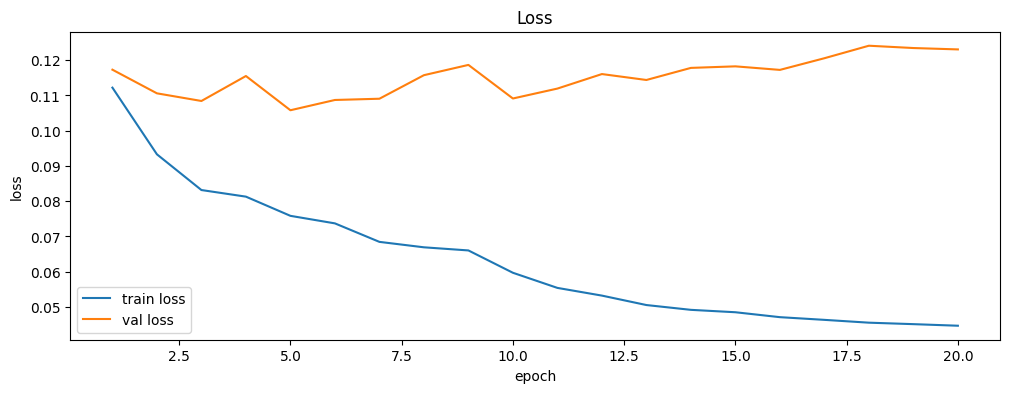

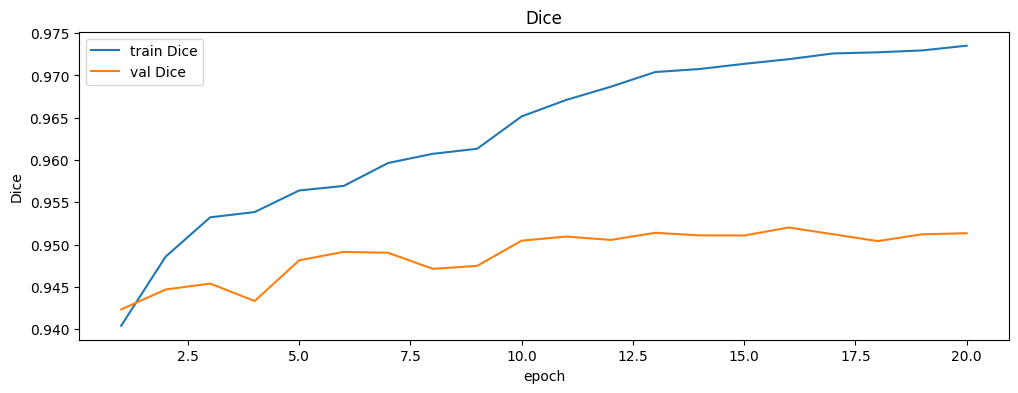

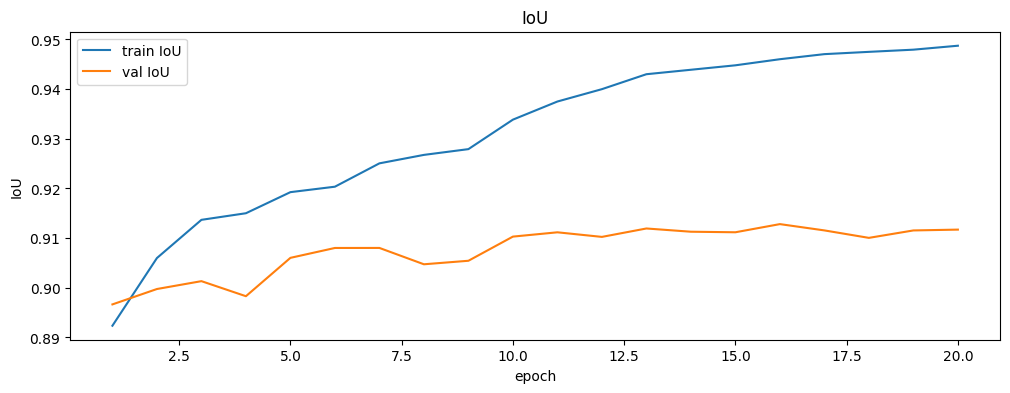

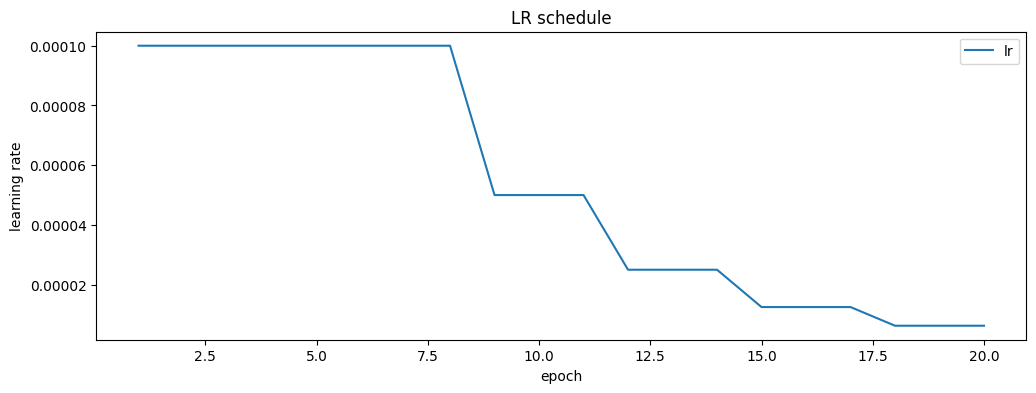

In [ ]:
history = {k: [] for k in ["train_loss","val_loss","train_iou","val_iou","train_dice","val_dice","train_acc","val_acc","lr"]}
best_dice = -1.0

EPOCHS_FROZEN = 5
EPOCHS_FINETUNE = 15

# ---- Stage 1: frozen backbone ----
for epoch in range(1, EPOCHS_FROZEN + 1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(va["loss"])  # :contentReference[oaicite:9]{index=9}
    lr = get_lr(optimizer)

    for k in ["loss","iou","dice","acc"]:
        history[f"train_{k}"].append(tr[k])
        history[f"val_{k}"].append(va[k])
    history["lr"].append(lr)

    if va["dice"] > best_dice:
        best_dice = va["dice"]
        save_checkpoint(best_path, model, optimizer, scheduler, epoch, best_dice, history)  # state_dict :contentReference[oaicite:10]{index=10}

    print(f"[frozen] Epoch {epoch:02d} | lr={lr:.2e} | val Dice={va['dice']:.3f} | best={best_dice:.3f}")

# ---- Stage 2: fine-tune backbone ----
for p in model.enc.body.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam([
    {"params": model.enc.body.parameters(), "lr": 1e-4},  # backbone маленький lr
    {"params": [p for p in model.parameters() if p.requires_grad and p not in set(model.enc.body.parameters())], "lr": 5e-4},
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       factor=0.5,
                                                       patience=2,
                                                       #verbose=True
                                                       )  # :contentReference[oaicite:11]{index=11}

for epoch2 in range(1, EPOCHS_FINETUNE + 1):
    epoch = EPOCHS_FROZEN + epoch2

    tr = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(va["loss"])
    lr = optimizer.param_groups[0]["lr"]  # backbone lr для логов

    for k in ["loss","iou","dice","acc"]:
        history[f"train_{k}"].append(tr[k])
        history[f"val_{k}"].append(va[k])
    history["lr"].append(lr)

    if va["dice"] > best_dice:
        best_dice = va["dice"]
        save_checkpoint(best_path, model, optimizer, scheduler, epoch, best_dice, history)

    print(f"[finetune] Epoch {epoch:02d} | backbone_lr={optimizer.param_groups[0]['lr']:.2e} | val Dice={va['dice']:.3f} | best={best_dice:.3f}")

print("Best checkpoint:", best_path)
plot_history(history)


### Загрузка лучшего чекпоинта и визуализация

Loaded best epoch: 16 best_dice: 0.9520150513752647


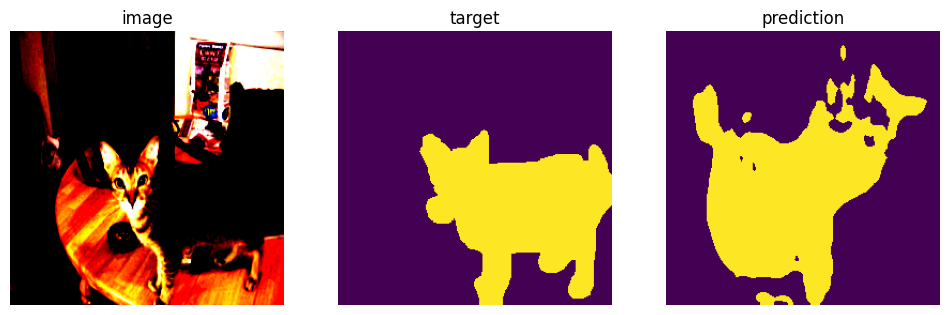

In [ ]:
ckpt = load_checkpoint(best_path, model, map_location=DEVICE)
print("Loaded best epoch:", ckpt["epoch"], "best_dice:", ckpt["best_score"])
show_pred(model, pet_test, idx=0)


In [ ]:
from pathlib import Path
import torch

CKPT_PATH = Path("/content/checkpoints/best_resnetseg_pet.pth")
assert CKPT_PATH.exists(), f"Checkpoint not found: {CKPT_PATH}"

# 1) Инициализация модели (класс ResNetSeg должен быть определён выше в ноутбуке)
# encoder_trainable можно ставить как угодно — это влияет только на requires_grad, не на форму весов.
model_resnetseg = ResNetSeg(encoder_trainable=True).to(DEVICE)

# 2) Загрузка чекпоинта на нужное устройство (map_location — чтобы не упасть на CPU/GPU несовпадении) :contentReference[oaicite:1]{index=1}
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# 3) Универсально: поддержим оба формата
#    a) полный чекпоинт dict с ключом "model_state" (как мы сохраняли)
#    b) чистый state_dict
state = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt

missing, unexpected = model_resnetseg.load_state_dict(state, strict=False)
print("Loaded:", CKPT_PATH.name)
print("Missing keys:", len(missing), "| Unexpected keys:", len(unexpected))

# (опционально) если это полный чекпоинт — покажем метаданные
if isinstance(ckpt, dict):
    print("epoch:", ckpt.get("epoch"), "| best_score:", ckpt.get("best_score"))

model_resnetseg.eval()


Loaded: best_resnetseg_pet.pth
Missing keys: 0 | Unexpected keys: 0
epoch: 16 | best_score: 0.9520150513752647


ResNetSeg(
  (enc): ResNetEncoder(
    (body): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Module(
        (0): Module(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Module(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=

In [23]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_img(x):
    # x: (3,H,W) normalized
    x = x.detach().cpu()
    x = x * IMAGENET_STD + IMAGENET_MEAN
    return x.clamp(0, 1)

@torch.no_grad()
def show_pred_denorm(model, ds, idx=0, normalized_input=True, thr=0.5):
    model.eval()
    img, mask = ds[idx]

    logits = model(img.unsqueeze(0).to(DEVICE)).cpu()
    pred = (torch.sigmoid(logits)[0,0] > thr).numpy()

    img_disp = denorm_img(img) if normalized_input else img.cpu()
    img_np = img_disp.permute(1,2,0).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_np); ax[0].set_title("image"); ax[0].axis("off")
    ax[1].imshow(mask.numpy()); ax[1].set_title("target"); ax[1].axis("off")
    ax[2].imshow(pred); ax[2].set_title("prediction"); ax[2].axis("off")
    plt.show()


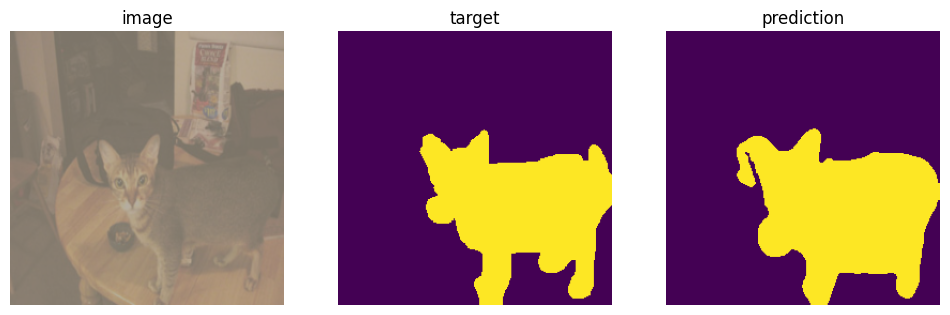

In [ ]:
show_pred_denorm(model_resnetseg, pet_test, idx=0, normalized_input=True, thr=0.5)


# U-Net

U-Net мы учим с нуля, поэтому ImageNet-нормализацию лучше выключить (если вы её включали для ResNet-бэкбона).

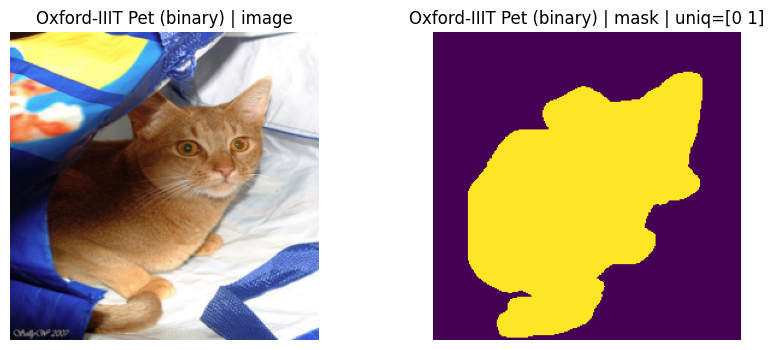

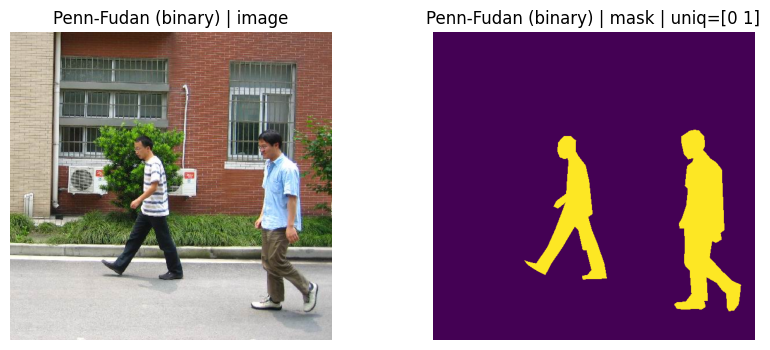

In [ ]:
# Вернуть "обычный" трансформ без normalize
pet_train.tf = SegTransform(size=(256,256), hflip_p=0.5)
pet_test.tf  = SegTransform(size=(256,256), hflip_p=0.0)

show_sample(pet_train, idx=0, title="Oxford-IIIT Pet (binary)")
show_sample(penn, idx=0, title="Penn-Fudan (binary)")

##  U-Net (PyTorch)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    """Upscaling then concat skip then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
            # после concat каналов будет in_ch, приводим к out_ch
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            # транспонированная свёртка уменьшает число каналов в 2 раза перед concat
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)

        # На случай несовпадения размеров (из-за округлений) — паддинг до skip
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY != 0 or diffX != 0:
            x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])

        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    """
    U-Net для бинарной сегментации:
    вход:  (B,3,H,W)
    выход: (B,1,H,W) logits
    """
    def __init__(self, n_channels=3, n_classes=1, base=64, bilinear=True):
        super().__init__()
        self.inc = DoubleConv(n_channels, base)
        self.down1 = Down(base, base*2)
        self.down2 = Down(base*2, base*4)
        self.down3 = Down(base*4, base*8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base*8, base*16 // factor)

        self.up1 = Up(base*16, base*8 // factor, bilinear)
        self.up2 = Up(base*8,  base*4 // factor, bilinear)
        self.up3 = Up(base*4,  base*2 // factor, bilinear)
        self.up4 = Up(base*2,  base, bilinear)
        self.outc = OutConv(base, n_classes)

    def forward(self, x):
        x1 = self.inc(x)      # skip1
        x2 = self.down1(x1)   # skip2
        x3 = self.down2(x2)   # skip3
        x4 = self.down3(x3)   # skip4
        x5 = self.down4(x4)   # bottleneck

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        return self.outc(x)   # logits


## Обучение “как раньше”: scheduler + best checkpoint + графики

- Используем тот же лосс BCEWithLogitsLoss (он объединяет sigmoid+BCELoss и стабильнее численно).
docs.pytorch.org

- Scheduler — ReduceLROnPlateau, step после валидации.
docs.pytorch.org

- Чекпоинт — сохраняем state_dict (рекомендуемая практика).


Epoch 01 | lr=1.00e-03 | train: loss=0.4925, IoU=0.559, Dice=0.700, Acc=0.760 | val: loss=0.4536, IoU=0.609, Dice=0.743, Acc=0.791 | bestDice=0.743
Epoch 02 | lr=1.00e-03 | train: loss=0.4004, IoU=0.641, Dice=0.769, Acc=0.821 | val: loss=0.4038, IoU=0.647, Dice=0.773, Acc=0.825 | bestDice=0.773
Epoch 03 | lr=1.00e-03 | train: loss=0.3624, IoU=0.677, Dice=0.796, Acc=0.842 | val: loss=0.3280, IoU=0.709, Dice=0.819, Acc=0.861 | bestDice=0.819
Epoch 04 | lr=1.00e-03 | train: loss=0.3313, IoU=0.703, Dice=0.815, Acc=0.858 | val: loss=0.3418, IoU=0.710, Dice=0.817, Acc=0.845 | bestDice=0.819
Epoch 05 | lr=1.00e-03 | train: loss=0.2992, IoU=0.731, Dice=0.835, Acc=0.872 | val: loss=0.3168, IoU=0.734, Dice=0.834, Acc=0.867 | bestDice=0.834
Epoch 06 | lr=1.00e-03 | train: loss=0.2741, IoU=0.752, Dice=0.849, Acc=0.885 | val: loss=0.2520, IoU=0.776, Dice=0.864, Acc=0.895 | bestDice=0.864
Epoch 07 | lr=1.00e-03 | train: loss=0.2513, IoU=0.771, Dice=0.862, Acc=0.895 | val: loss=0.2546, IoU=0.771, Dic

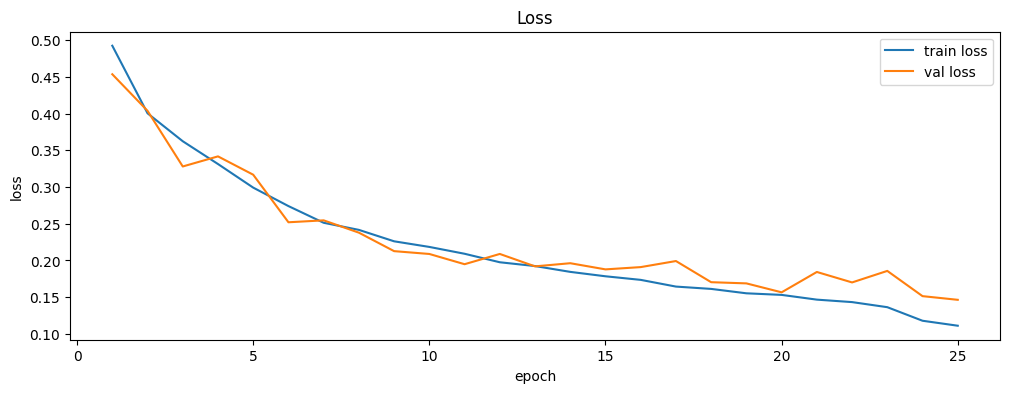

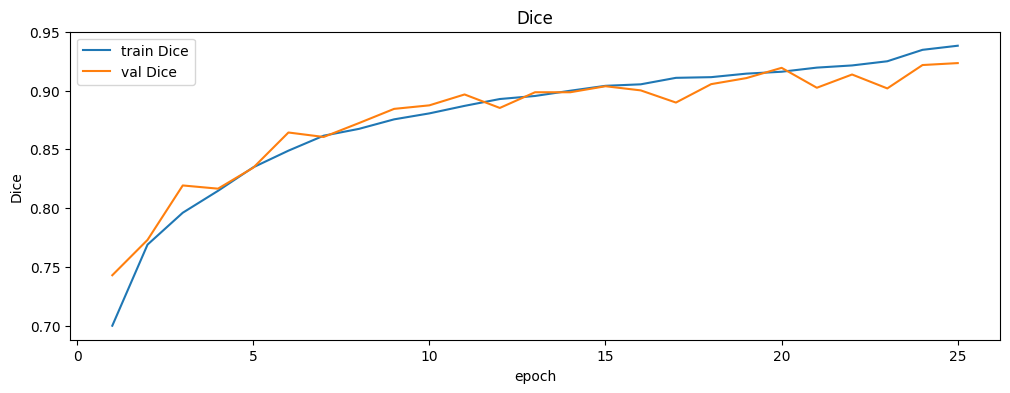

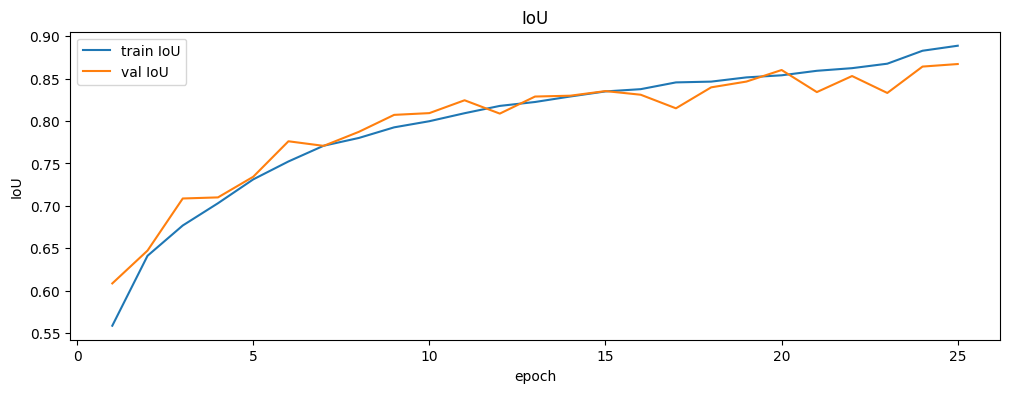

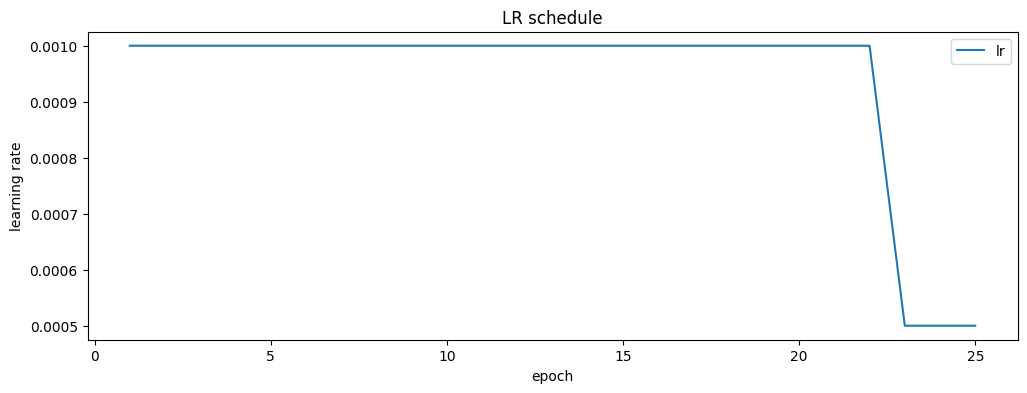

In [ ]:
from pathlib import Path
import torch.nn as nn

model = UNet(base=64, bilinear=True).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()  # :contentReference[oaicite:5]{index=5}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, #verbose=True
)  # :contentReference[oaicite:6]{index=6}

ckpt_dir = Path("./checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
best_path = ckpt_dir / "best_unet_pet.pth"

history = {k: [] for k in ["train_loss","val_loss","train_iou","val_iou","train_dice","val_dice","train_acc","val_acc","lr"]}
best_dice = -1.0

EPOCHS = 25

for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(va["loss"])  # step после validate :contentReference[oaicite:7]{index=7}
    lr = get_lr(optimizer)

    for k in ["loss","iou","dice","acc"]:
        history[f"train_{k}"].append(tr[k])
        history[f"val_{k}"].append(va[k])
    history["lr"].append(lr)

    if va["dice"] > best_dice:
        best_dice = va["dice"]
        save_checkpoint(best_path, model, optimizer, scheduler, epoch, best_dice, history)  # state_dict :contentReference[oaicite:8]{index=8}

    print(
        f"Epoch {epoch:02d} | lr={lr:.2e} | "
        f"train: loss={tr['loss']:.4f}, IoU={tr['iou']:.3f}, Dice={tr['dice']:.3f}, Acc={tr['acc']:.3f} | "
        f"val: loss={va['loss']:.4f}, IoU={va['iou']:.3f}, Dice={va['dice']:.3f}, Acc={va['acc']:.3f} | "
        f"bestDice={best_dice:.3f}"
    )

print("Best checkpoint:", best_path)
plot_history(history)


## Загрузка лучшего и визуальная проверка

Loaded best epoch: 25 best_dice: 0.9233627316096554


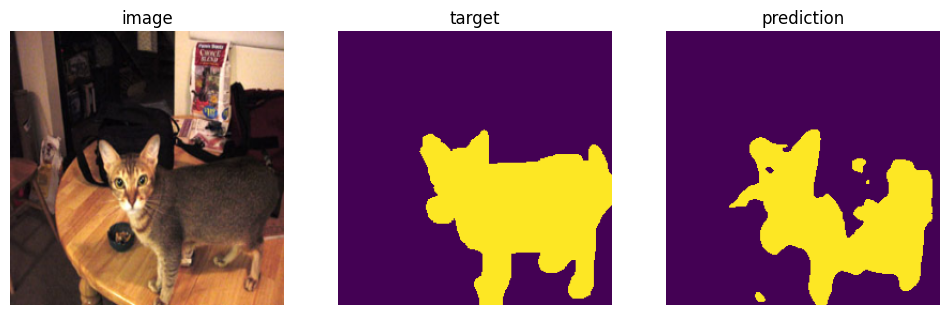

In [ ]:
ckpt = load_checkpoint(best_path, model, map_location=DEVICE)
print("Loaded best epoch:", ckpt["epoch"], "best_dice:", ckpt["best_score"])
show_pred(model, pet_test, idx=0)


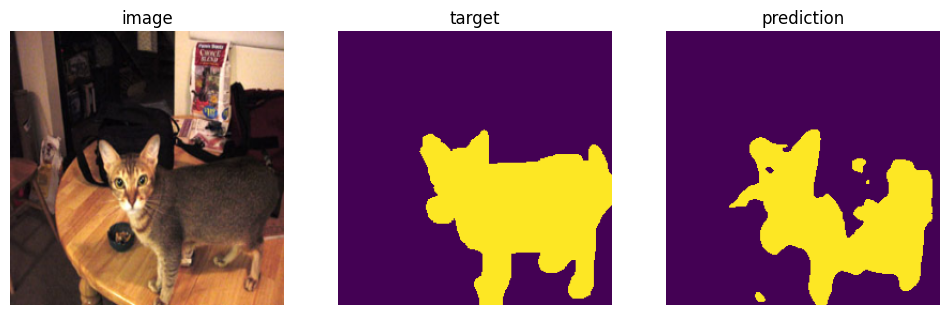

In [ ]:
show_pred_denorm(model, pet_test, idx=0, normalized_input=False, thr=0.5)

# DeepLabV3

## Трансформ под pretrained segmentation

Pretrained segmentation модели в torchvision ожидают вход в [0,1] и нормализацию mean/std ImageNet; также часто тренируются при min size ~520 (мы можем оставить 256 для скорости).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.transforms import functional as TF

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class SegTransformNorm(SegTransform):
    def __init__(self, size=(256,256), hflip_p=0.5):
        super().__init__(size=size, hflip_p=hflip_p)

    def __call__(self, img_pil, mask_pil):
        img_t, mask_t = super().__call__(img_pil, mask_pil)  # img: [0,1]
        img_t = TF.normalize(img_t, mean=IMAGENET_MEAN, std=IMAGENET_STD)
        return img_t, mask_t


In [ ]:
pet_train.tf = SegTransformNorm(size=(256,256), hflip_p=0.5)
pet_test.tf  = SegTransformNorm(size=(256,256), hflip_p=0.0)


## DeepLabV3 из torchvision + замена головы под бинарный выход

- DeepLabV3_ResNet50_Weights.DEFAULT = COCO_WITH_VOC_LABELS_V1 (21 класс).

- Мы грузим веса, затем заменяем последний conv на 1 канал.

- DeepLabV3/FCN в torchvision из коробки обучены на COCO subset с VOC-метками (21 класс), поэтому мы обязательно меняем голову под бинарный выход; это нормальный паттерн fine-tuning.

In [ ]:
class DeeplabBinary(nn.Module):
    """
    Обёртка: torchvision DeepLabV3 -> возвращаем logits (B,1,H,W)
    """
    def __init__(self, pretrained=True):
        super().__init__()

        if pretrained:
            weights = DeepLabV3_ResNet50_Weights.DEFAULT  # = COCO_WITH_VOC_LABELS_V1
            model = deeplabv3_resnet50(weights=weights)
        else:
            model = deeplabv3_resnet50(weights=None)

        # classifier: DeepLabHead(...) = Sequential(..., last_conv)
        model.classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)

        # aux_classifier может присутствовать (в зависимости от сборки/весов)
        if getattr(model, "aux_classifier", None) is not None:
            model.aux_classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)

        self.model = model

    def forward(self, x):
        out = self.model(x)["out"]  # torchvision segmentation returns dict
        return out


## Обучение “продвинутое”: scheduler + best checkpoint + история

Функции из предыдущих шагов:
train_one_epoch, evaluate, plot_history, save_checkpoint, load_checkpoint, get_lr, show_pred.

In [20]:
from pathlib import Path

model = DeeplabBinary(pretrained=True).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # для pretrained обычно меньше

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, #verbose=True
)

ckpt_dir = Path("./checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
best_path = ckpt_dir / "best_deeplabv3_pet_binary.pth"

history = {k: [] for k in ["train_loss","val_loss","train_iou","val_iou","train_dice","val_dice","train_acc","val_acc","lr"]}
best_dice = -1.0

EPOCHS = 15

for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(va["loss"])
    lr = get_lr(optimizer)

    for k in ["loss","iou","dice","acc"]:
        history[f"train_{k}"].append(tr[k])
        history[f"val_{k}"].append(va[k])
    history["lr"].append(lr)

    if va["dice"] > best_dice:
        best_dice = va["dice"]
        save_checkpoint(best_path, model, optimizer, scheduler, epoch, best_dice, history)

    print(
        f"Epoch {epoch:02d} | lr={lr:.2e} | "
        f"train: loss={tr['loss']:.4f}, IoU={tr['iou']:.3f}, Dice={tr['dice']:.3f}, Acc={tr['acc']:.3f} | "
        f"val: loss={va['loss']:.4f}, IoU={va['iou']:.3f}, Dice={va['dice']:.3f}, Acc={va['acc']:.3f} | "
        f"bestDice={best_dice:.3f}"
    )

print("Best checkpoint:", best_path)
plot_history(history)


Epoch 01 | lr=1.00e-04 | train: loss=0.1901, IoU=0.867, Dice=0.924, Acc=0.940 | val: loss=0.1363, IoU=0.891, Dice=0.939, Acc=0.955 | bestDice=0.939
Epoch 02 | lr=1.00e-04 | train: loss=0.1147, IoU=0.902, Dice=0.946, Acc=0.961 | val: loss=0.1107, IoU=0.903, Dice=0.946, Acc=0.961 | bestDice=0.946
Epoch 03 | lr=1.00e-04 | train: loss=0.0975, IoU=0.910, Dice=0.951, Acc=0.965 | val: loss=0.1057, IoU=0.906, Dice=0.948, Acc=0.961 | bestDice=0.948
Epoch 04 | lr=1.00e-04 | train: loss=0.0853, IoU=0.917, Dice=0.955, Acc=0.968 | val: loss=0.1085, IoU=0.902, Dice=0.946, Acc=0.960 | bestDice=0.948
Epoch 05 | lr=1.00e-04 | train: loss=0.0788, IoU=0.921, Dice=0.957, Acc=0.970 | val: loss=0.1098, IoU=0.900, Dice=0.944, Acc=0.959 | bestDice=0.948
Epoch 06 | lr=1.00e-04 | train: loss=0.0748, IoU=0.923, Dice=0.958, Acc=0.971 | val: loss=0.1003, IoU=0.910, Dice=0.950, Acc=0.963 | bestDice=0.950
Epoch 07 | lr=1.00e-04 | train: loss=0.0689, IoU=0.927, Dice=0.961, Acc=0.973 | val: loss=0.1085, IoU=0.906, Dic

NameError: name 'plot_history' is not defined

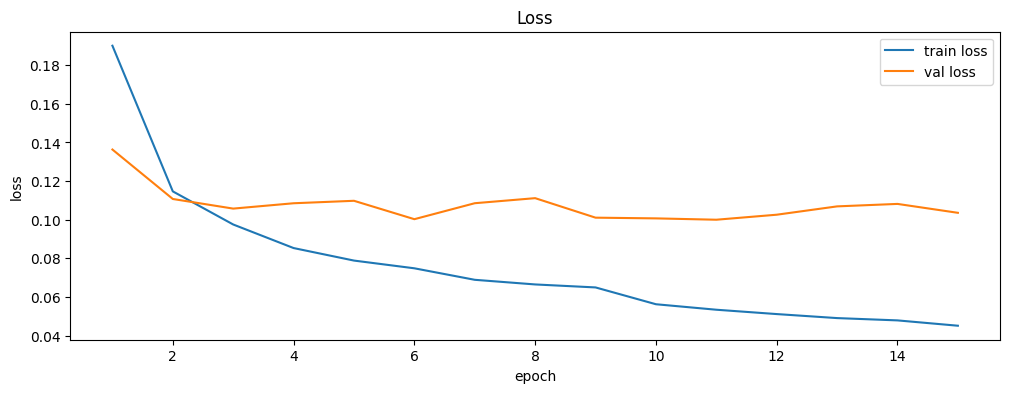

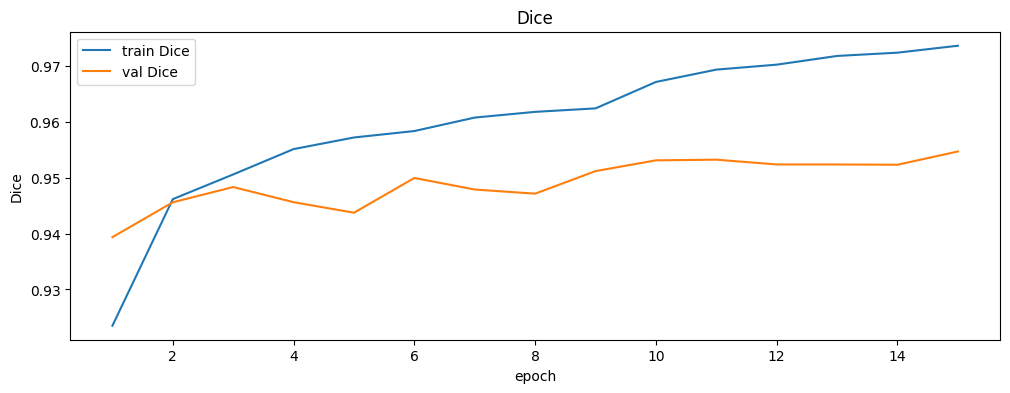

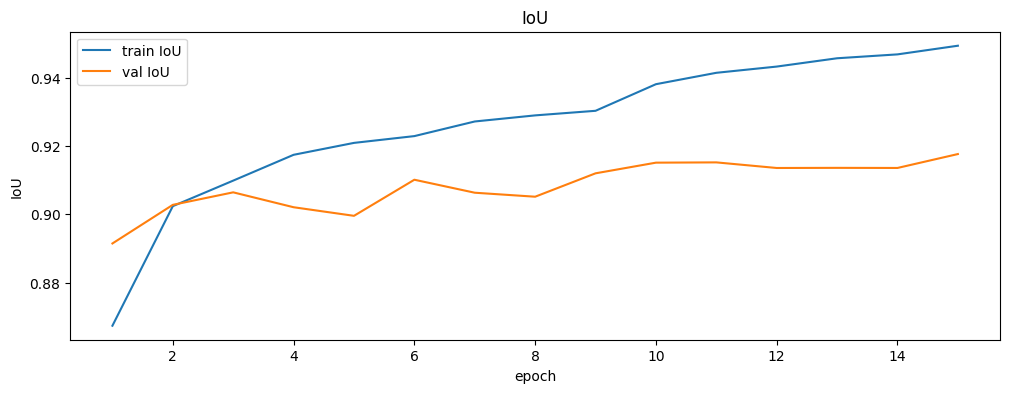

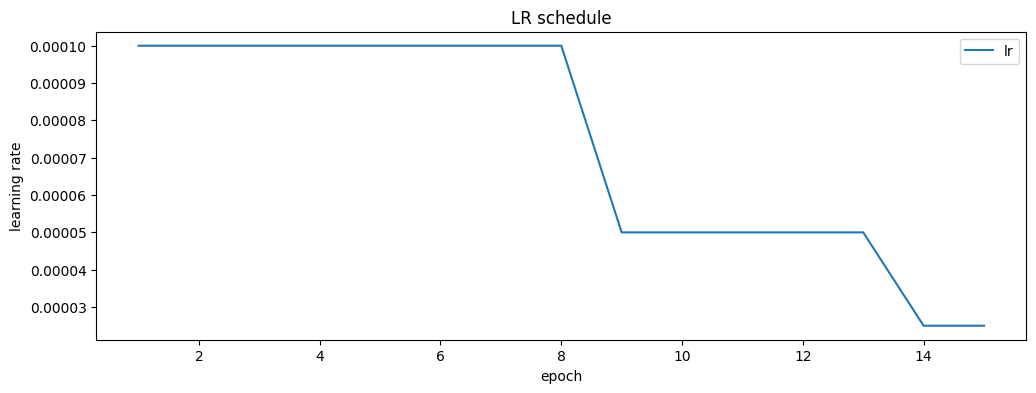

In [22]:
plot_history(history)

## Проверка лучшего чекпоинта и визуализация

Loaded best epoch: 15 best_dice: 0.9547275019728619


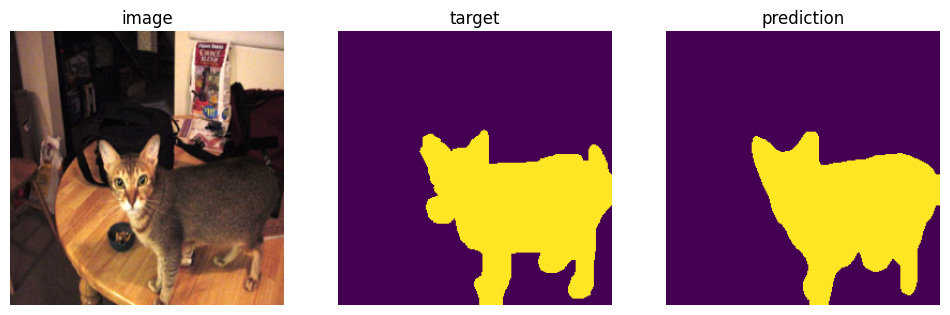

In [25]:
ckpt = load_checkpoint(best_path, model, map_location=DEVICE)
print("Loaded best epoch:", ckpt["epoch"], "best_dice:", ckpt["best_score"])

show_pred_denorm(model, pet_test, idx=0, normalized_input=True, thr=0.5)
#show_pred(model, pet_test, idx=0)


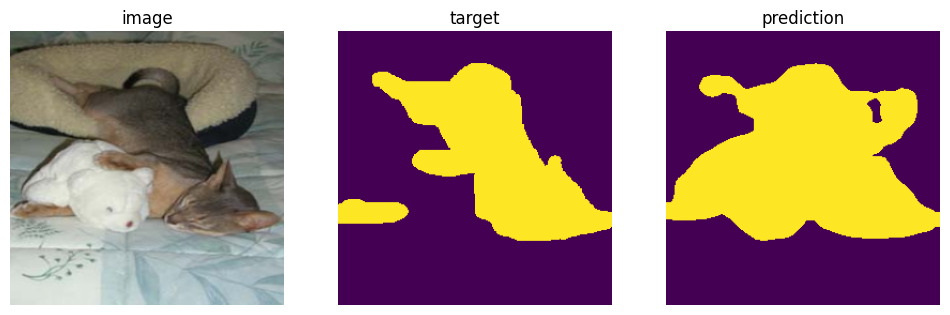

In [26]:
show_pred_denorm(model, pet_test, idx=5, normalized_input=True, thr=0.5)

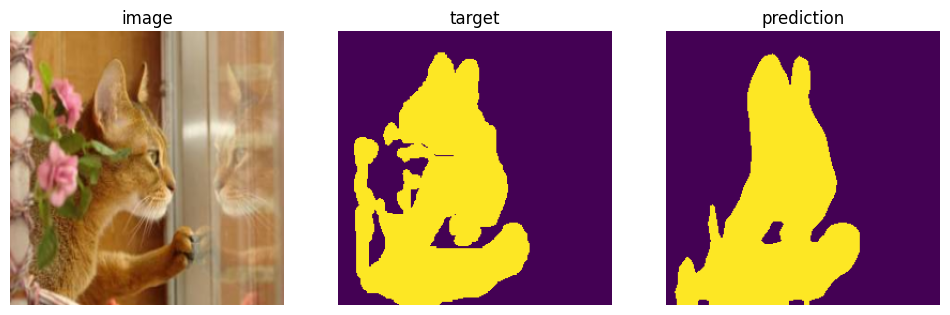

In [27]:
show_pred_denorm(model, pet_test, idx=15, normalized_input=True, thr=0.5)